### 0: battery
### 1: organic
### 2: trash
### 3: recycling

In [ ]:
!pip install opencv-python
!pip install --upgrade --force-reinstall pandas
import cv2 as cv
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

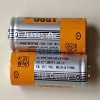

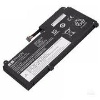

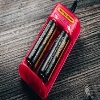

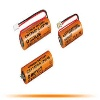

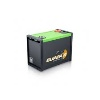

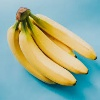

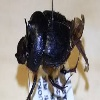

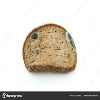

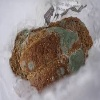

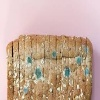

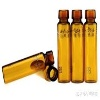

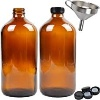

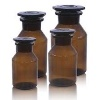

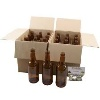

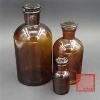

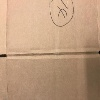

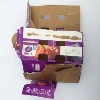

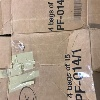

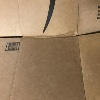

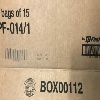

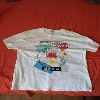

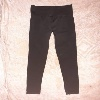

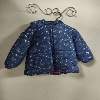

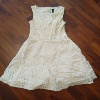

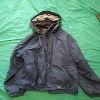

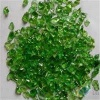

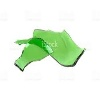

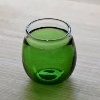

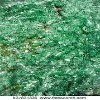

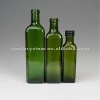

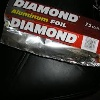

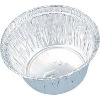

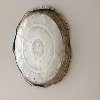

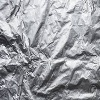

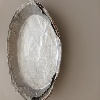

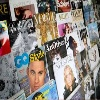

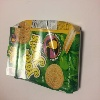

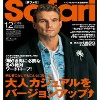

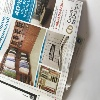

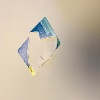

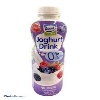

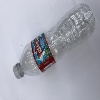

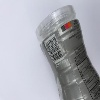

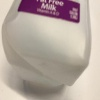

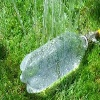

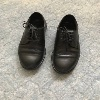

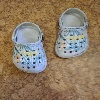

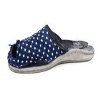

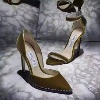

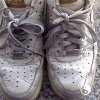

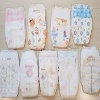

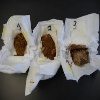

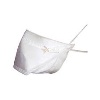

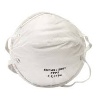

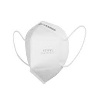

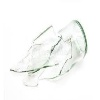

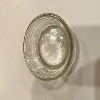

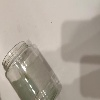

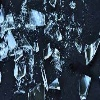

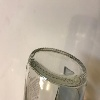

In [15]:
from IPython.display import display, Image
directory = r"garbage_classification"
for category in os.listdir(directory):
    path = os.path.join(directory, category)
    for img in os.listdir(path)[:5]:
        image = cv.imread(os.path.join(path, img))
        image = cv.resize(image, (100, 100));
        display(Image(data=cv.imencode('.jpg', image)[1].tobytes()))

In [16]:
directory = r"garbage_classification"
train_data = []
test_data = []
train_class = []
test_class = []
for category in os.listdir(directory):
    path = os.path.join(directory, category)
    n = len(os.listdir(path))
    train_num = round(0.6 * n)
    
    if(category == "battery"):
        category = 0
    elif(category == "biological"):
        category = 1
    elif(category == "trash"):
        category = 2
    else:
        category = 3
        # recycling
    for img in os.listdir(path)[:train_num]:
        image = cv.imread(os.path.join(path, img))
        image = cv.resize(image, (100, 100));
        train_data.append(image)
        train_class.append(category)
    for img in os.listdir(path)[train_num:]:
        image = cv.imread(os.path.join(path, img))
        image = cv.resize(image, (100, 100));
        test_data.append(image)
        test_class.append(category)

In [17]:
train_data = np.array(train_data)
train_class = np.array(train_class)
test_data = np.array(test_data)
test_class = np.array(test_class)

In [19]:
!pip install imblearn
#praying to jesus that this works - SMOTE ????
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
    
train_rows=len(train_data)
train_data = train_data.reshape(train_rows,-1)

train_data, train_class = sm.fit_resample(train_data, train_class)
train_data = train_data.reshape(-1,100,100,3)

In [20]:
from collections import Counter
counts = Counter(train_class)
for value, count in counts.items():
    print(f"{value} occurs {count} times")

0 occurs 7732 times
1 occurs 7732 times
3 occurs 7732 times
2 occurs 7732 times


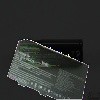

0


In [26]:
display(Image(data=cv.imencode('.jpg', train_data[10000])[1].tobytes()))
print(train_class[10000])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D

model = Sequential()

model.add(Conv2D(64, kernel_size = 3, activation = 'relu', input_shape = train_data.shape[1:]))
model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics=['accuracy'])

In [27]:
from keras.utils import to_categorical
train_class = to_categorical(train_class)
test_class = to_categorical(test_class)

In [28]:
model.fit(train_data, train_class, epochs=10, validation_data=(test_data, test_class))

Epoch 1/10
967/967 [==============================] - 292s 302ms/step - loss: 0.9678 - accuracy: 0.6126 - val_loss: 1.1077 - val_accuracy: 0.7380
Epoch 2/10
967/967 [==============================] - 300s 310ms/step - loss: 0.5752 - accuracy: 0.7737 - val_loss: 1.1391 - val_accuracy: 0.7467
Epoch 3/10
967/967 [==============================] - 287s 297ms/step - loss: 0.4735 - accuracy: 0.8233 - val_loss: 1.1700 - val_accuracy: 0.7396
Epoch 4/10
967/967 [==============================] - 286s 296ms/step - loss: 0.6254 - accuracy: 0.7613 - val_loss: 1.2838 - val_accuracy: 0.7198
Epoch 5/10
967/967 [==============================] - 292s 302ms/step - loss: 0.4043 - accuracy: 0.8329 - val_loss: 2.0466 - val_accuracy: 0.6562
Epoch 6/10
967/967 [==============================] - 309s 320ms/step - loss: 0.2533 - accuracy: 0.8977 - val_loss: 1.6974 - val_accuracy: 0.6575
Epoch 7/10
967/967 [==============================] - 305s 316ms/step - loss: 0.2464 - accuracy: 0.9002 - val_loss: 2.3053 -

In [34]:
prediction = model.predict(test_data)
prediction

194/194 [==============================] - 23s 119ms/step


array([[2.4381527e-03, 4.9520062e-32, 2.4274905e-04, 9.9731916e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.1715006e-08, 2.1025438e-10, 7.9055417e-01, 2.0944583e-01],
       ...,
       [4.2048946e-02, 4.3449000e-02, 4.6831113e-01, 4.4619098e-01],
       [2.6301697e-02, 1.1041000e-01, 1.8916215e-01, 6.7412621e-01],
       [9.0501318e-03, 5.9071038e-02, 7.7836835e-01, 1.5351045e-01]],
      dtype=float32)

In [39]:
predictions = [np.argmax(x) for x in prediction]
test_class = [np.argmax(x) for x in test_class]

In [41]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(test_class, predictions , normalize='pred')
result

array([[0.14153439, 0.03557312, 0.06492335, 0.04646613],
       [0.05687831, 0.13833992, 0.07574391, 0.05673759],
       [0.00925926, 0.02371542, 0.03516682, 0.0555148 ],
       [0.79232804, 0.80237154, 0.82416592, 0.84128149]])

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(test_class, predictions)

0.583373610439826

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model!")

Saved model!
